<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/master/concatenation_experiments_and_error_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import joblib
import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import scipy
from scipy import ndimage
from sklearn import metrics
from sklearn.utils import shuffle
import io
import collections

%tensorflow_version 2.x
import tensorflow as tf

# Load Data from Drive

In [0]:
obs = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/obs.pkl')
prefs = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/pref.pkl')
conv_acts = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/convAct.pkl')
dens_acts = joblib.load('/content/drive/My Drive/_data/PreferenceExtraction/densAct.pkl')

# Modelling Functions

1. Metrics
2. CNN
3. DNN
4. Training code
5. Error analysis

In [0]:
def get_val_auc(logs):
      for key in logs:
        if key.startswith('val_auc'):
          return logs[key]

class BestStats(tf.keras.callbacks.Callback):
  """A callback to keep track of the best val accuracy and auc seen so far."""
  def on_train_begin(self, logs):
      self.bestMetric = -float('inf')
      self.bestLogs = None
      self.bestTrain = -float('inf')
      self.num_epochs = 0

  def on_epoch_end(self, epoch, logs):
    self.num_epochs += 1
    self.bestTrain = max(self.bestTrain, logs.get('accuracy'))

    val_accuracy = logs.get('val_accuracy')
    if val_accuracy == None:
      return 

    val_auc = get_val_auc(logs)
    
    metric = (val_accuracy + val_auc) / 2.0

    if metric > self.bestMetric:
      self.bestMetric = metric
      self.bestLogs = logs

In [0]:
def cnn(reg_amount, drop_rate, xs_shape):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_amount), input_shape=xs_shape[1:]),
    tf.keras.layers.Conv2D(16, 1, activation='relu', strides=1, kernel_regularizer=tf.keras.regularizers.l2(reg_amount)),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(drop_rate),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_amount)),
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(.01),
                loss='binary_crossentropy',
                metrics=['accuracy',
                        tf.keras.metrics.AUC()
                        ],
                )
  return model

In [0]:
def dnn(reg_amount, drop_rate, layer_sizes):

  layers = []
  for layer_size in layer_sizes:
    layers.append(tf.keras.layers.Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_amount)))
    layers.append(tf.keras.layers.Dropout(drop_rate))

  model = tf.keras.models.Sequential(layers + [
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_amount))
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(.01),
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC()],
                )
  return model

In [0]:
def train_best_logs(xs, ys, prefs, num_train, num_val, do_summary, hparams, model, epochs):
  """Trains the model and retruns the logs of the best epoch. randomly splits the train and val data before training."""
  tf.keras.backend.clear_session()
  model = model(**hparams)
  xs, ys, prefs = shuffle(xs, ys, prefs)

  xs_val = xs[num_train:num_train+num_val]
  ys_val = ys[num_train:num_train+num_val]
  pref_val = prefs[num_train:num_train+num_val]
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0)
  best_stats = BestStats()
  model.fit(xs[:num_train], ys[:num_train], epochs=epochs, batch_size=256, validation_freq=1, callbacks=[best_stats, early_stopping], validation_data=(xs_val, ys_val), verbose=0)
  ys_val_hat = model.predict(xs_val)
  if do_summary:
    model.summary()
    print("Best train accuracy:", best_stats.bestTrain)
    print("Number of epochs:", best_stats.num_epochs)
    
  ys_val_hat = (ys_val_hat.flatten() > 0.5).astype(int)
  errors = (ys_val_hat != ys_val)
  pct_diff = pd.Series(pref_val[errors]).value_counts(normalize=True) - pd.Series(pref_val).value_counts(normalize=True)

  return best_stats.bestLogs, ys_val_hat, ys_val, pref_val, pct_diff

def multiple_train_ave(hparams, model, xs_for_train, ys, prefs, num_train, num_val, epochs, num_repeat = 10):
  """Trains the model multiple times with the same parameters and returns the average metrics"""
  start = time.time()
  all_val_auc = []
  all_val_accuracy = []

  pct_diffs = []
  do_summary = True
  for i in range(num_repeat):
    print('Doing training iteration no.', i+1)
    logs, ys_val_hat, ys_val, pref_val, pct_diff = train_best_logs(xs_for_train, ys, prefs, num_train, num_val, do_summary, hparams, model, epochs)
    all_val_auc.append(get_val_auc(logs))
    all_val_accuracy.append(logs.get('val_accuracy'))
    do_summary = False 
    pct_diffs.append(pct_diff)

  mean_val_auc = np.mean(all_val_auc)
  mean_val_accuracy = np.mean(all_val_accuracy)
  metric = (mean_val_auc + mean_val_accuracy) / 2.0
  print_data = ("mean_val_auc", mean_val_auc, "mean_val_accuracy", mean_val_accuracy, "metric", metric, "val_auc_std", np.std(all_val_auc), "val_accuracy_std", np.std(all_val_accuracy))

  end = time.time()

  return metric, print_data, ys_val_hat, ys_val, pref_val, pct_diffs

def train_eval(hparams, model, xs, ys, prefs, num_train, num_val, epochs):
    
    print("Model:", model)
    print("Shape of input:", xs.shape)
    print("Hyperparameters:", hparams)
    print("Number of training data:", num_train)
    print("Number of validation data:", num_val)
    print("Number of epochs:", epochs)
    
    metric, print_data, ys_val_hat, ys_val, pref_val, pct_diffs = multiple_train_ave(hparams, model, xs, ys, prefs, num_train, num_val, epochs)
    print("Results", print_data)

    return ys_val_hat, ys_val, pref_val, pct_diffs

In [0]:
def error_analysis_plot(y_pred, y_true, prefs):
    y_pred = (y_pred.flatten() > 0.5).astype(int)
    errors = (y_pred != y_true)
    prefs[prefs == -100] = -12
    plt.hist(prefs, bins=13, label='True values')
    plt.hist(prefs[errors], bins=13, label='Prediction errors')
    plt.ylabel('Number of occurrences')
    plt.xlabel('Human preference value')
    plt.legend()
    plt.show()

# Experiments

1. Train on 10K observation data
2. Train on all possible combination of concatenations with 50 data points

In [0]:
ys = (prefs > -6).astype(int)

## Experiment (1) - Train on 10K Observation

Model: <function cnn at 0x7fe12dbdcf28>
Shape of input: (23750, 14, 16, 5)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 14, 16, 5)}
Number of training data: 10000
Number of validation data: 2000
Number of epochs: 1000
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 15, 64)        1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 15, 32)        2080      
_________________________________________________________________
average_pooling2d (AveragePo (None, 6, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1344)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1344)

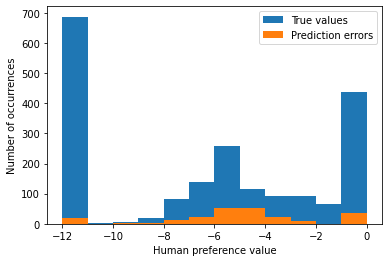

In [11]:
# Experiment No. 1
hparam = {"reg_amount": 0.0, "drop_rate": 0.0, "xs_shape": obs.shape}
ys_val_hat, ys_val, pref_val = train_eval(hparam, cnn, obs, ys, prefs, num_train=10000, num_val=2000, epochs=1000)
error_analysis_plot(ys_val_hat, ys_val, pref_val)

## Experiment (2) - Train on all possible concatenations of dense and conv activations

In [0]:
conv_acts_flat = conv_acts.reshape((23750, 12 * 14 * 16))

dens_acts_ch16 = dens_acts.reshape((23750, 2, 2, 16))
dens_act_pad_ch16 = np.zeros((23750, 12, 14, 16))
dens_act_pad_ch16[:dens_acts_ch16.shape[0], :dens_acts_ch16.shape[1],
                  :dens_acts_ch16.shape[2], :dens_acts_ch16.shape[3]] = dens_acts_ch16

dens_acts_ch64 = dens_acts.reshape((23750, 1, 1, 64))
dens_act_pad_ch64 = np.zeros((23750, 12, 14, 64))
dens_act_pad_ch64[:dens_acts_ch64.shape[0], :dens_acts_ch64.shape[1],
                  :dens_acts_ch64.shape[2], :dens_acts_ch64.shape[3]] = dens_acts_ch64

all_acts_flat = np.concatenate([conv_acts_flat, dens_acts], axis=1)
conv_dens_act_conc_on_x1 = np.concatenate([conv_acts, dens_act_pad_ch16], axis=1)
conv_dens_act_conc_on_x2 = np.concatenate([conv_acts, dens_act_pad_ch16], axis=2)
conv_dens_act_conc_on_x3 = np.concatenate([conv_acts, dens_act_pad_ch16], axis=3)
conv_dens_act_conc_on_ch = np.concatenate([conv_acts, dens_act_pad_ch64], axis=3)

del conv_acts, dens_acts, conv_acts_flat, dens_acts_ch16, dens_act_pad_ch16, dens_acts_ch64, dens_act_pad_ch64

Model: <function dnn at 0x7fcdf56a37b8>
Shape of input: (23750, 64)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'layer_sizes': (32,)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2080      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  33        
Total params: 2,113
Trainable params: 2,113
Non-trainable params: 0
_________________________________________________________________
Best train accuracy: 1.0
Number of epochs: 31
Doing training iteration no. 2
Doing training iteration no. 3
Doing training iter

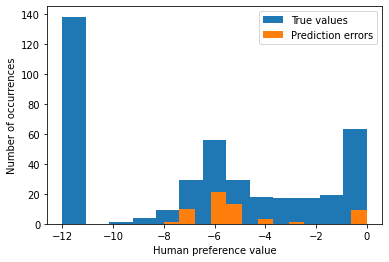

Model: <function dnn at 0x7fcdf56a37b8>
Shape of input: (23750, 2752)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'layer_sizes': (32,)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  88096     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  33        
Total params: 88,129
Trainable params: 88,129
Non-trainable params: 0
_________________________________________________________________
Best train accuracy: 0.9599999785423279
Number of epochs: 35
Doing training iteration no. 2
Doing training iteration no. 3


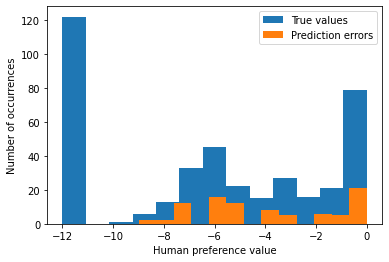

Model: <function cnn at 0x7fcdf56a3c80>
Shape of input: (23750, 12, 14, 16)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 12, 14, 16)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 13, 32)        2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 13, 16)        528       
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dropout (Dropout)            (None, 480)    

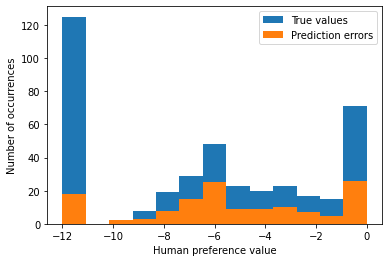

Model: <function cnn at 0x7fcdf56a3c80>
Shape of input: (23750, 24, 14, 16)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 24, 14, 16)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 13, 32)        2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 13, 16)        528       
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 6, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1056)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1056)   

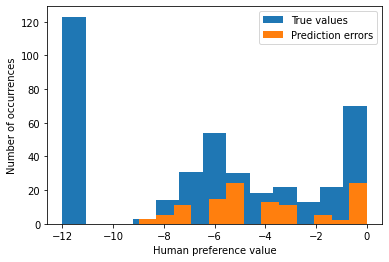

Model: <function cnn at 0x7fcdf56a3c80>
Shape of input: (23750, 12, 28, 16)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 12, 28, 16)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 27, 32)        2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 27, 16)        528       
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 13, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1040)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1040)   

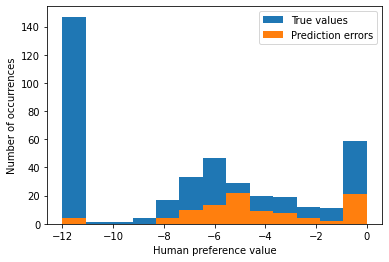

Model: <function cnn at 0x7fcdf56a3c80>
Shape of input: (23750, 12, 14, 32)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 12, 14, 32)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 13, 32)        4128      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 13, 16)        528       
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dropout (Dropout)            (None, 480)    

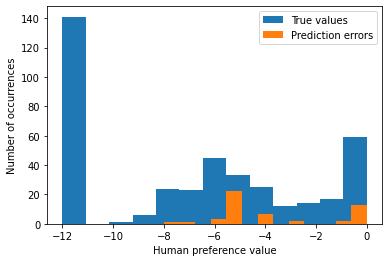

Model: <function cnn at 0x7fcdf56a3c80>
Shape of input: (23750, 12, 14, 80)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 12, 14, 80)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 13, 32)        10272     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 13, 16)        528       
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dropout (Dropout)            (None, 480)    

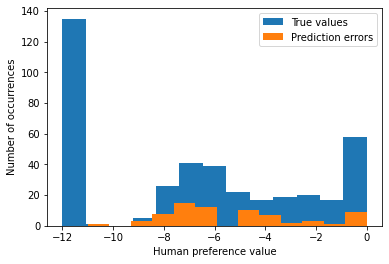

In [22]:
# Experiment No. 2

for xs in [
    dens_acts,
    all_acts_flat,
    conv_acts,
    conv_dens_act_conc_on_x1, 
    conv_dens_act_conc_on_x2,
    conv_dens_act_conc_on_x3,
    conv_dens_act_conc_on_ch]:

    if len(xs.shape) == 2:
        hparam = {"reg_amount": 0.0, "drop_rate": 0.0, "layer_sizes": (32,)}
        mod = dnn
    else:
        hparam = {"reg_amount": 0.0, "drop_rate": 0.0, "xs_shape": xs.shape}
        mod = cnn
    
    ys_val_hat, ys_val, pref_val = train_eval(hparam, mod, xs, ys, prefs, num_train=50, num_val=400, epochs=400)
    error_analysis_plot(ys_val_hat, ys_val, pref_val)

### Summary of results of Experiment 2

| Xs                       | AUC   |
|--------------------------|-------|
| dens_acts                | 0.871 |
| all_acts_flat            | 0.838 |
| conv_acts                | 0.811 |
| conv_dens_act_conc_on_x1 | 0.879 |
| conv_dens_act_conc_on_x2 | 0.893 |
| conv_dens_act_conc_on_x3 | 0.868 |
| conv_dens_act_conc_on_ch | 0.887 |

## Experiment 3 - Looking for Systematic Errors

1. Take the best model of experiment 2 (`conv_dens_act_conc_on_ch`)
2. Train the model 10 times with 50 different samples of 50 datests
3. Measure the mean deviation between the proportion of values in the validation dataset and the proportion of values for which the model makes errors (e.g. validation dataset has 10% of 6 but 30% of error are for 6s, 20% difference would signal systematic error)

In [42]:
hparam = {"reg_amount": 0.0, "drop_rate": 0.0, "xs_shape": xs.shape}
ys_val_hat, ys_val, pref_val, pct_diffs = train_eval(hparam, cnn, conv_dens_act_conc_on_ch, ys, prefs, num_train=50, num_val=400, epochs=400)

Model: <function cnn at 0x7fcdf56a3c80>
Shape of input: (23750, 12, 14, 80)
Hyperparameters: {'reg_amount': 0.0, 'drop_rate': 0.0, 'xs_shape': (23750, 12, 14, 80)}
Number of training data: 50
Number of validation data: 400
Number of epochs: 400
Doing training iteration no. 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 13, 32)        10272     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 13, 16)        528       
_________________________________________________________________
average_pooling2d (AveragePo (None, 5, 6, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0         
_________________________________________________________________
dropout (Dropout)            (None, 480)    

In [56]:
# Some model have differences as big as 20% for certain preference values
pd.concat(pct_diffs, axis=1).fillna(0).max().sort_values(ascending=False).round(4)

8    0.1929
2    0.1893
5    0.1815
4    0.1787
3    0.1722
7    0.1428
6    0.1363
0    0.1299
9    0.1261
1    0.0867
dtype: float64

In [55]:
# For no preference value all model training make sysetmatic mistakes
pd.concat(pct_diffs, axis=1).fillna(0).mean().sort_values(ascending=False).round(4)

8    0.0415
4    0.0331
9    0.0319
6    0.0252
3    0.0060
2    0.0035
7    0.0012
1    0.0012
0    0.0008
5    0.0000
dtype: float64